In [59]:
%run dataFormating.ipynb

/home/emma/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,22,28,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/emma/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (14,15,16,17,18,20,21,22,25,26,27,30,33,34,35,36,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/emma/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,22,28,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/emma/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (14,15,16,17,18,20,21,22,25,26,27,30,3

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from pandas.plotting import scatter_matrix, parallel_coordinates

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from ipywidgets import FloatProgress
from IPython.display import display

from math import *

# Re-usable functions

In [61]:
# This function fit a KMeans clustering model on the data, for each number of clusters in a specified range.
# It displays the silhouette analysis plot for each number of clusters and outputs the silhouette scores
# The higher the silhouette score, the more distinct the clusters are. In a good clustering, all clusters raise above the average
# Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def tryKmeans(dataset, rangeNbClusters=[2, 3, 4, 5]):
    results = []
    
    # For each number of clusters
    for n_clusters in rangeNbClusters:
        # Create a subplot with 1 row and 1 column, make it possible to easily add plots in the function later if needed
        fig, ax = plt.subplots()
        fig.set_size_inches(12, 6)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(dataset) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(dataset)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(dataset, cluster_labels)
        
        # Save the silhouette score and the cluster assignement labels
        results.append([n_clusters, silhouette_avg, clusterer.labels_])

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        
    return results

In [69]:
# This function takes the initial data, result of tryKmeans and a chosen number of clusters
# It returns the label assignements of the sample
# If specified, it plots the parallel coordinates plot
def detailsKmeans(initData, kmeansResult, nbClusters, displayParallelCoord = False, clusterLabels = []):
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    
    # Displays
    if displayParallelCoord:
        nbGroups = ceil(len(initData.columns) / 8)
        print("Will split columns into {} groups".format(nbGroups))
        progressBar = FloatProgress(value = 0.0, min = 0.0, max = nbGroups)
        display(progressBar)
        # The data is split into several groups of columns for display
        for i in range(nbGroups):
            # Plot the data for the selected columns
            rangeMin = i * 8
            rangeMax = min(len(initData.columns), i * 8 + 9)
            labelledData = pd.concat([initData.iloc[:,rangeMin:rangeMax], assignements], axis = 1, join = "inner")
            fig, ax = plt.subplots()
            fig.set_size_inches(17, 3)
            ax = parallel_coordinates(labelledData, 'Index of cluster')
            
            # Beautification
            plt.xticks(rotation=60)
            if len(clusterLabels) > 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles, clusterLabels)
            plt.show()
            
            progressBar.value += 1.0
    
    return assignements

# Can data be clustered according to the answers given to the before questionnaire?

## If scientific questions are coded by answers

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


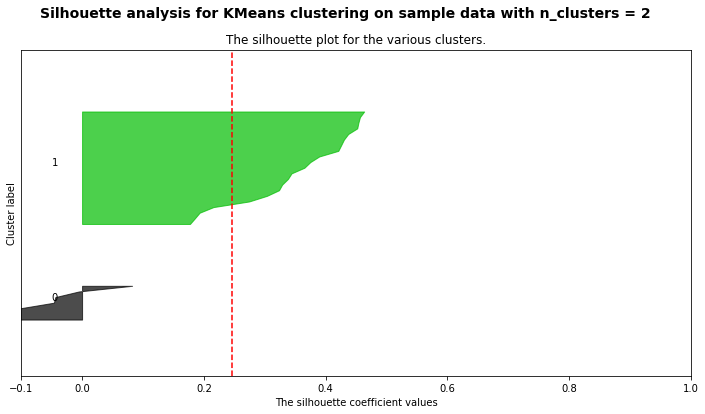

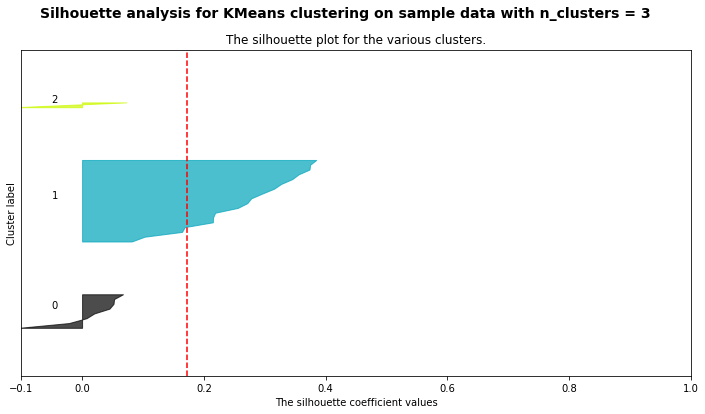

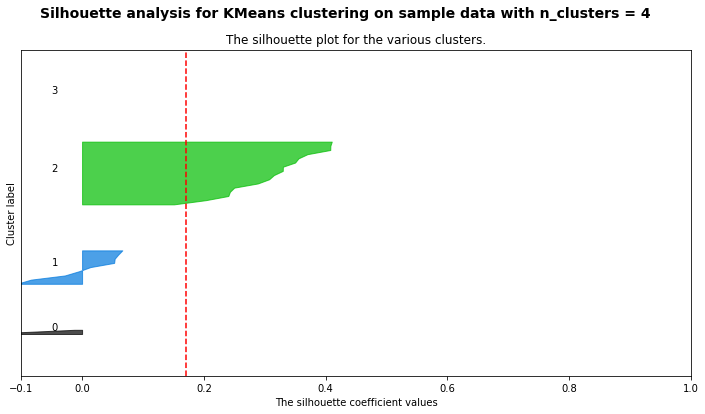

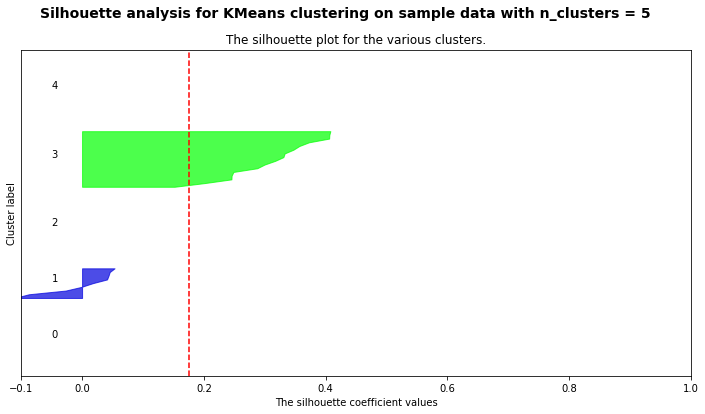

,Number of clusters,Average silhouette score,Label assignements
0,2,0.246608,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
1,3,0.172316,"[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ..."
2,4,0.171492,"[2, 2, 2, 3, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, ..."
3,5,0.176175,"[3, 3, 3, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, ..."


In [63]:
# Convert DataFrame to matrix
beforeMat = beforeForms.as_matrix()
# Standardise data
beforeMat = preprocessing.scale(beforeMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeResults = tryKmeans(beforeMat)
# Format results as a DataFrame
beforeResults = pd.DataFrame(data=beforeResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
beforeResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


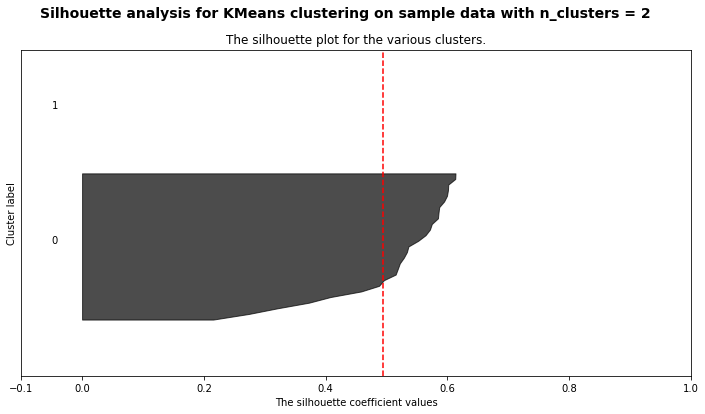

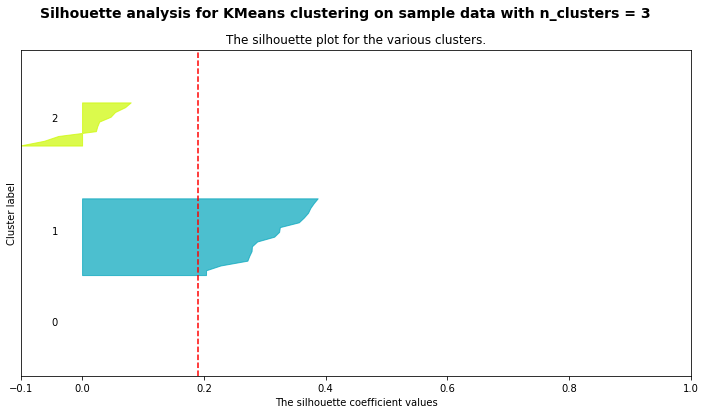

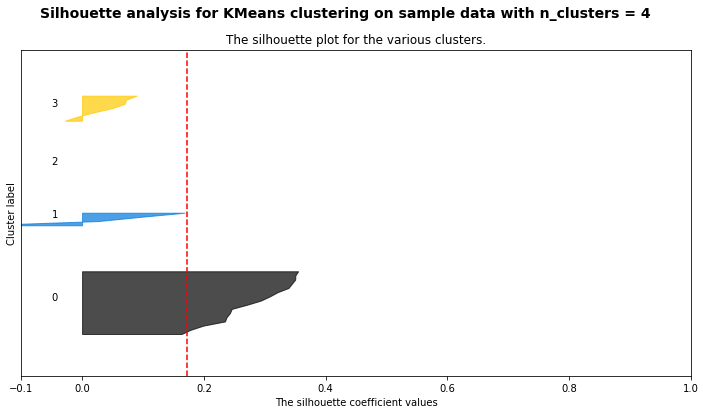

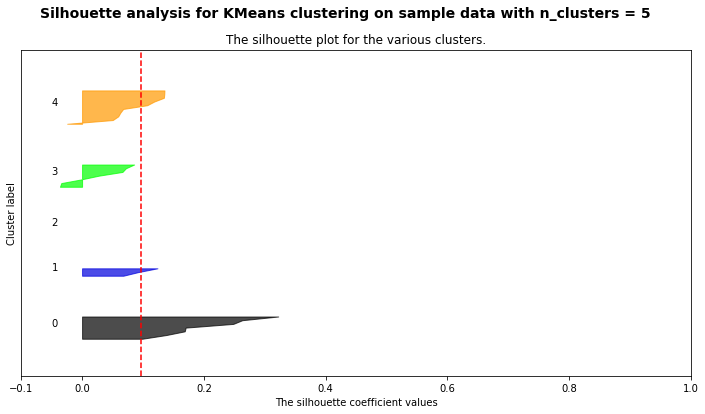

,Number of clusters,Average silhouette score,Label assignements
0,2,0.493893,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,0.190986,"[1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, ..."
2,4,0.171978,"[0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 1, 0, 3, ..."
3,5,0.097141,"[0, 4, 4, 0, 4, 3, 3, 3, 4, 0, 0, 4, 4, 0, 3, ..."


In [64]:
# Convert DataFrame to matrix
beforeCorrectedMat = beforeCorrectedForms.as_matrix()
# Standardise data
beforeCorrectedMat = preprocessing.scale(beforeCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeCorrectedResults = tryKmeans(beforeCorrectedMat)
# Format results as a DataFrame
beforeCorrectedResults = pd.DataFrame(data=beforeCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
beforeCorrectedResults

Conclusion: No interesting clustering (01/12/2017)

# Can data be clustered according to the answers given to the after questionnaire?

## If scientific questions are coded by answers

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


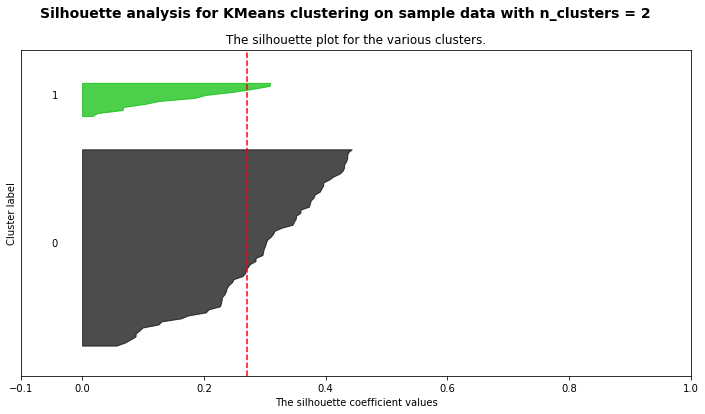

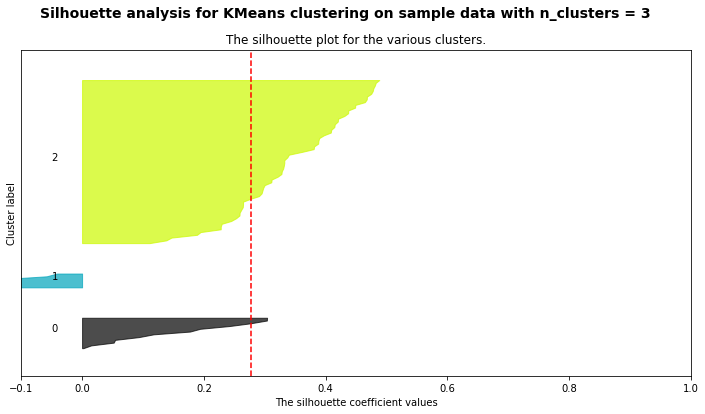

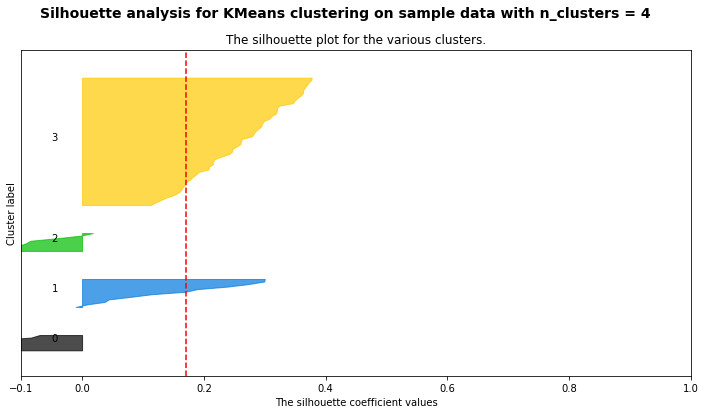

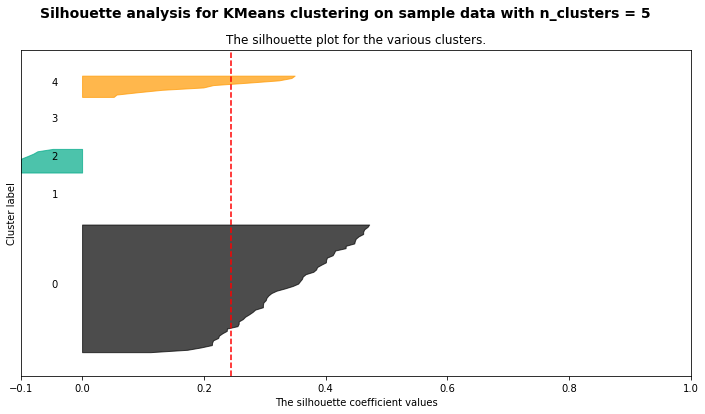

,Number of clusters,Average silhouette score,Label assignements
0,2,0.271154,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,3,0.278158,"[2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, ..."
2,4,0.171363,"[3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, ..."
3,5,0.245262,"[0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, ..."


In [65]:
# Convert DataFrame to matrix
afterMat = afterForms.as_matrix()
# Standardise the data
afterMat = preprocessing.scale(afterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterResults = tryKmeans(afterMat)
# Format results as a DataFrame
afterResults = pd.DataFrame(data=afterResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
afterResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


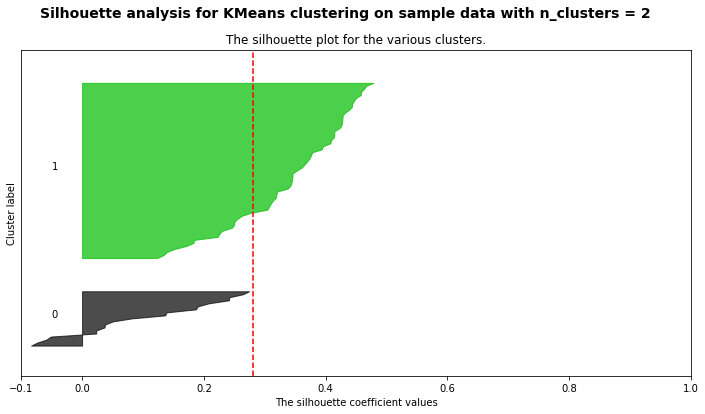

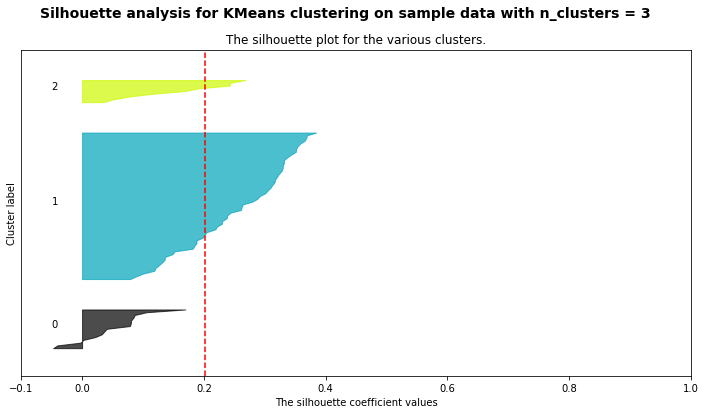

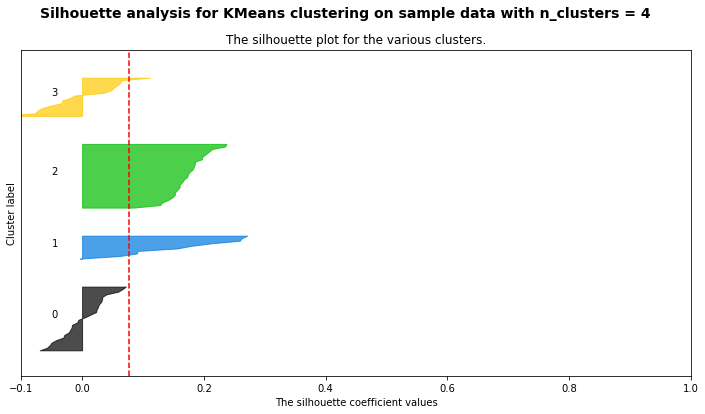

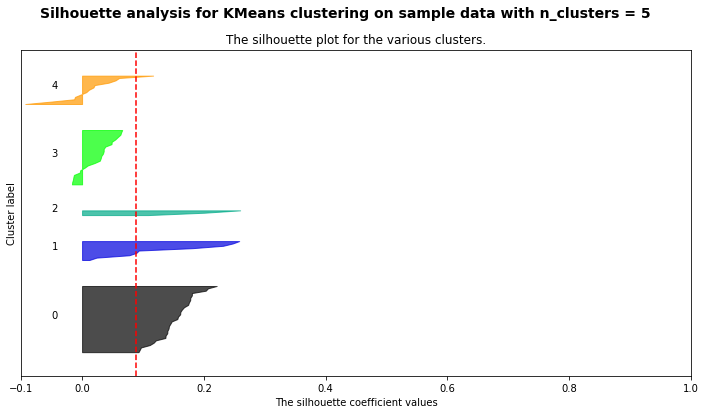

,Number of clusters,Average silhouette score,Label assignements
0,2,0.281605,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, ..."
1,3,0.202643,"[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, ..."
2,4,0.077370,"[3, 3, 3, 0, 2, 2, 2, 3, 2, 2, 0, 2, 2, 1, 0, ..."
3,5,0.089285,"[4, 3, 4, 3, 0, 0, 0, 4, 0, 0, 3, 0, 0, 1, 3, ..."


In [66]:
# Convert DataFrame to matrix
afterCorrectedMat = afterCorrectedForms.as_matrix()
# Standardise the data
afterCorrectedMat = preprocessing.scale(afterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterCorrectedResults = tryKmeans(afterCorrectedMat)
# Format results as a DataFrame
afterCorrectedResults = pd.DataFrame(data=afterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
afterCorrectedResults

Conclusion: No interesting clustering, but it would be interesting to see if two-clustering works better with more data (01/12/2017)

# Can data be clustered according to the answers given to the questionnaire?

## If scientific questions are coded by answers

### If only before and after questionnaires are used

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


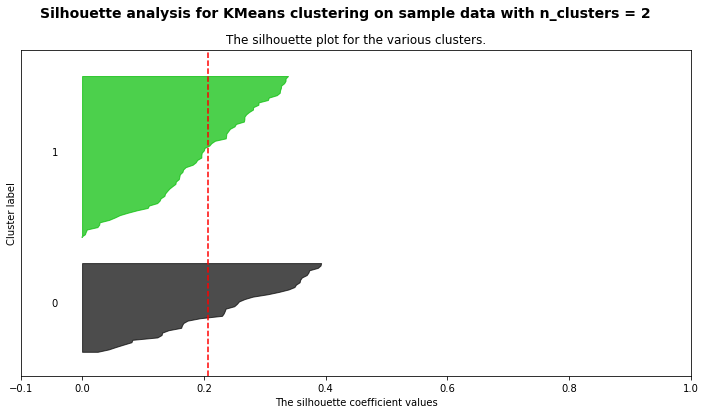

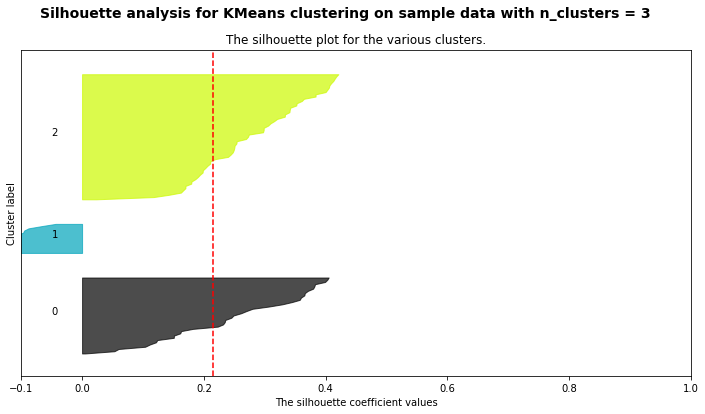

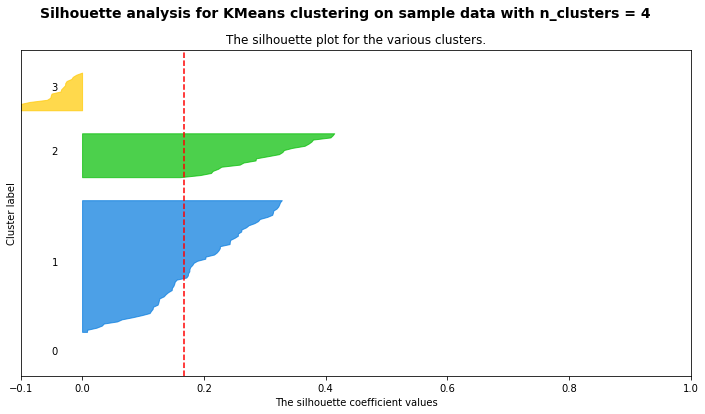

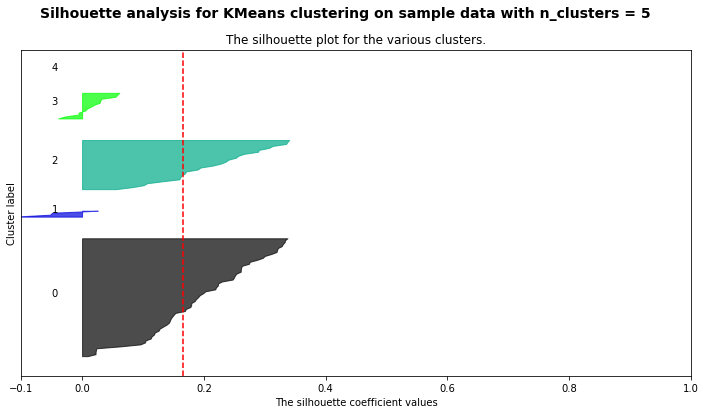

,Number of clusters,Average silhouette score,Label assignements
0,2,0.207263,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,0.215355,"[2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4,0.167837,"[1, 1, 1, 1, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, ..."
3,5,0.165504,"[0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, ..."


In [67]:
# Convert DataFrame to matrix
defMat = defForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defMat = preprocessing.scale(defMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defResults = tryKmeans(defMat)
# Format results as a DataFrame
defResults = pd.DataFrame(data=defResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
defResults

Conclusion: The data could be clustered in two groups
Note: The silhouette coefficient probably never goes very high because of the binary aspect of most of the data (30/11/2017)

Hypothesis: The two groups identified by the clustering algorithm correspond to the "before" and "after" questionnaires.
Note: The temporality feature was not included in the clustering algorithm

Will split columns into 17 groups


A Jupyter Widget

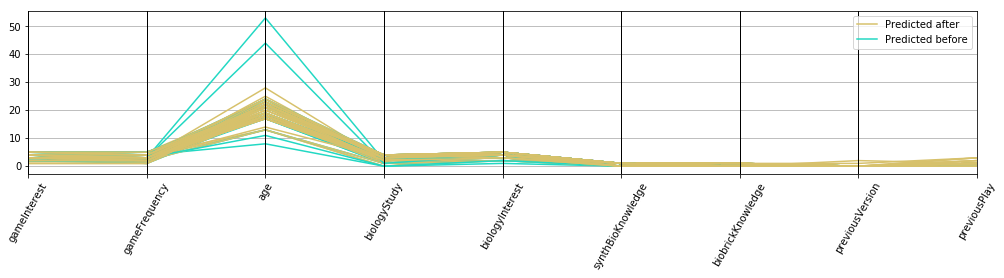

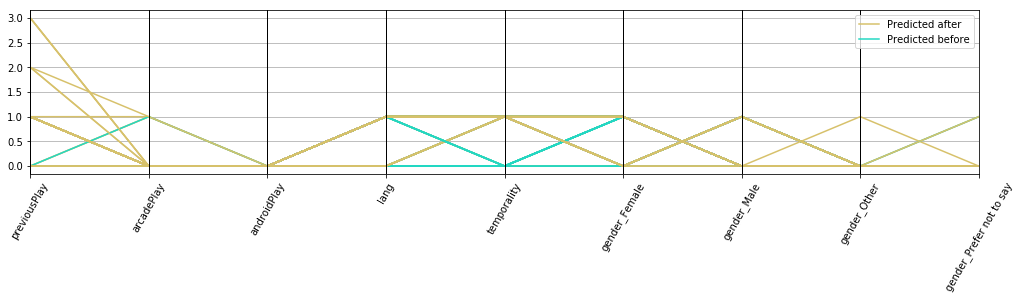

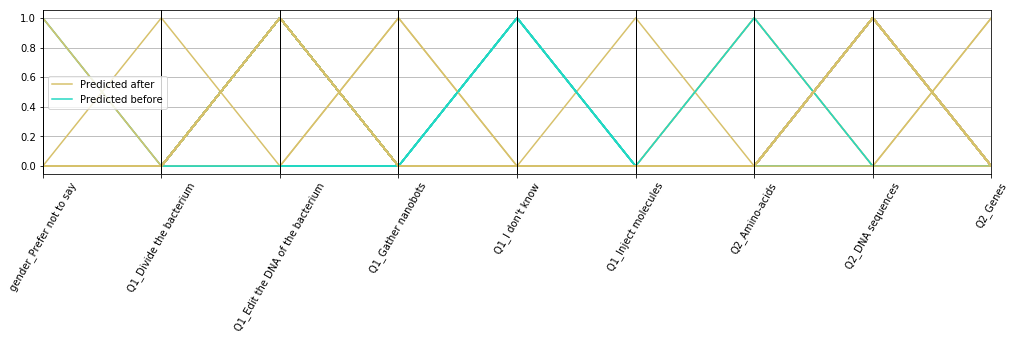

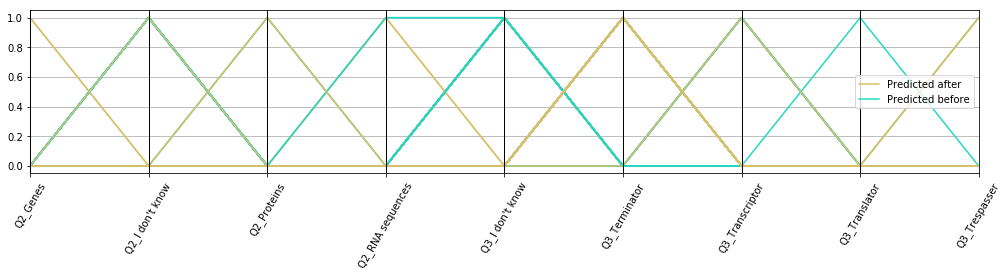

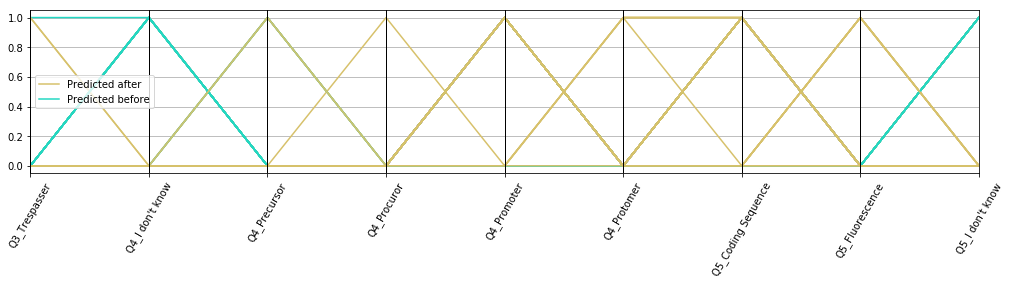

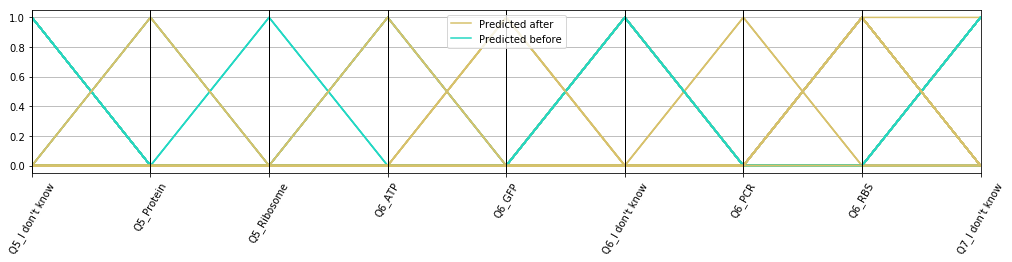

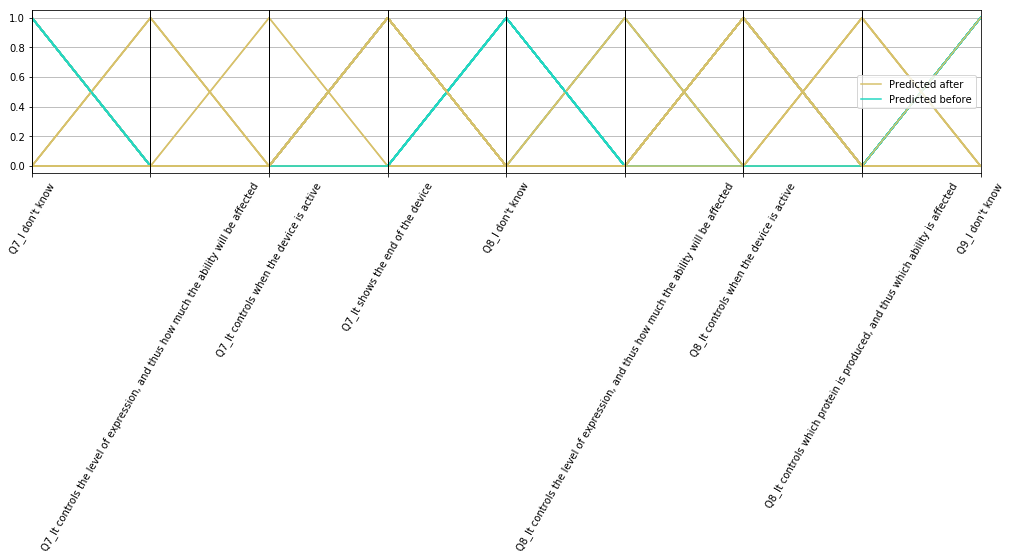

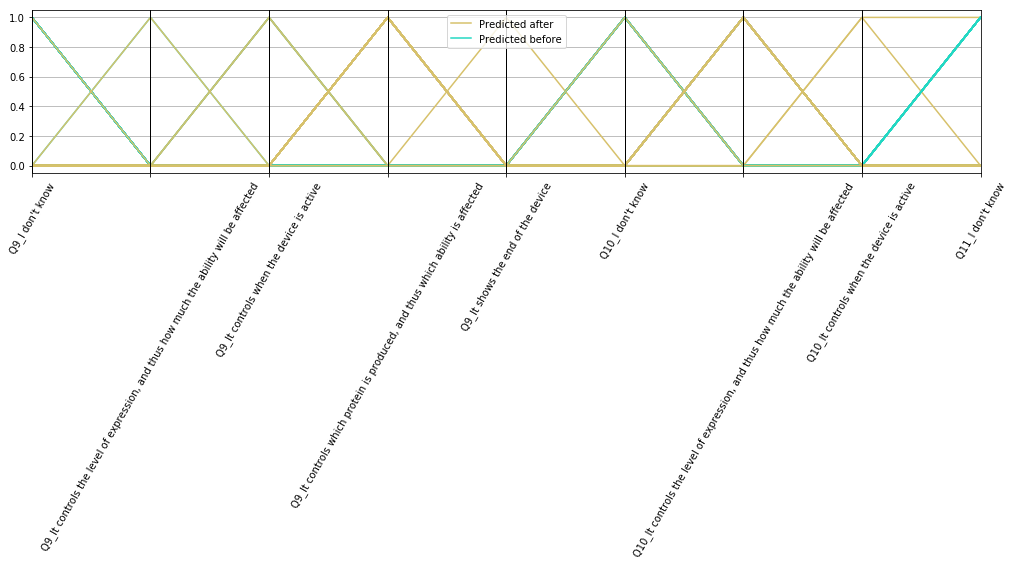

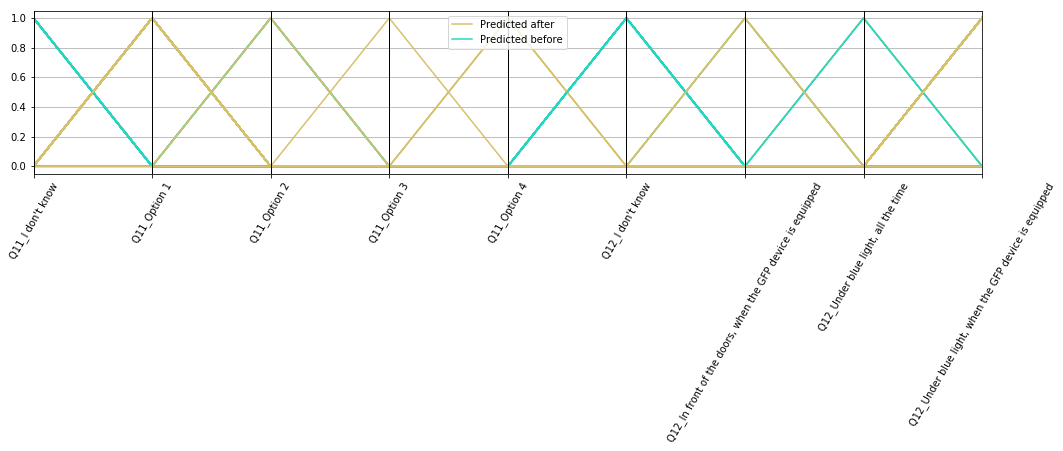

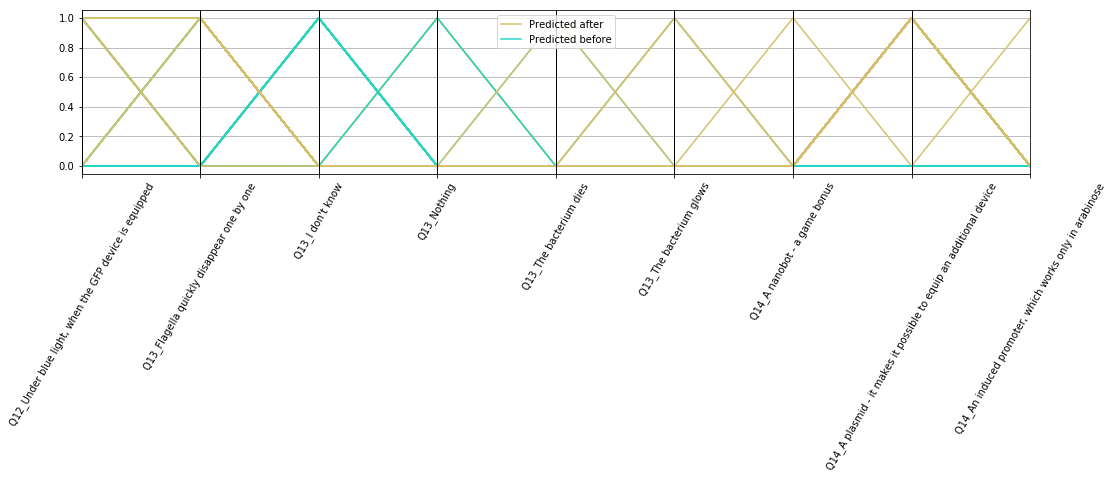

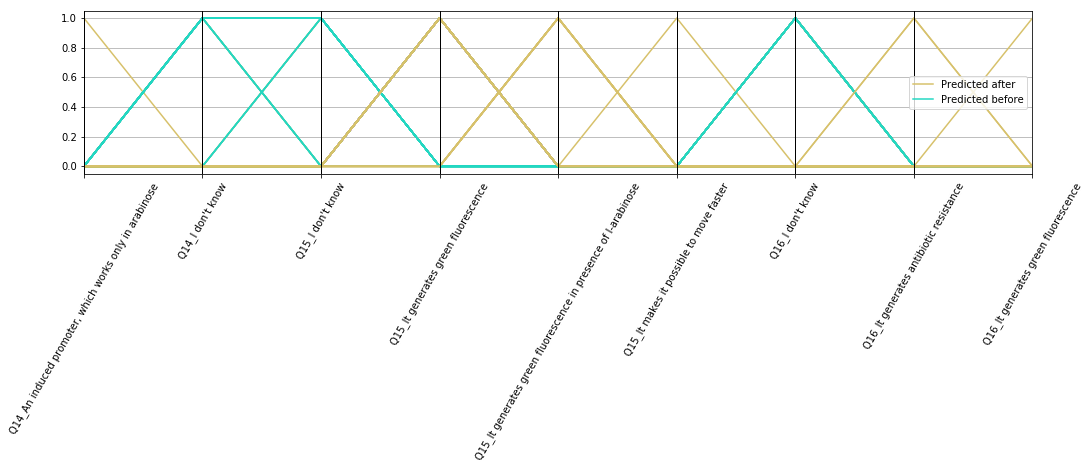

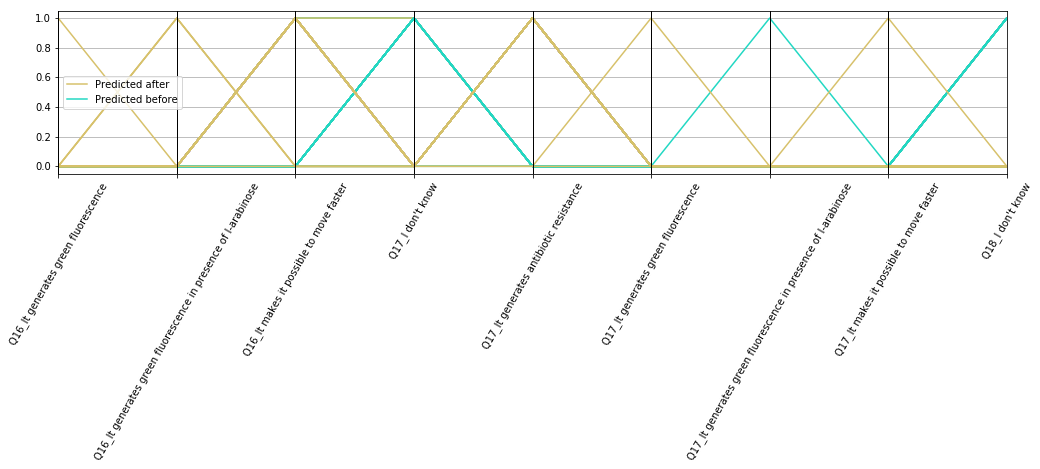

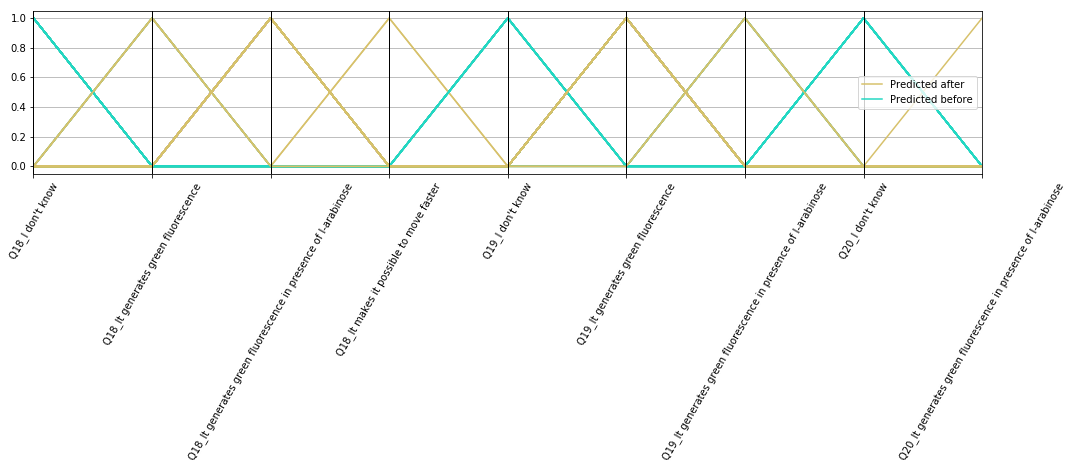

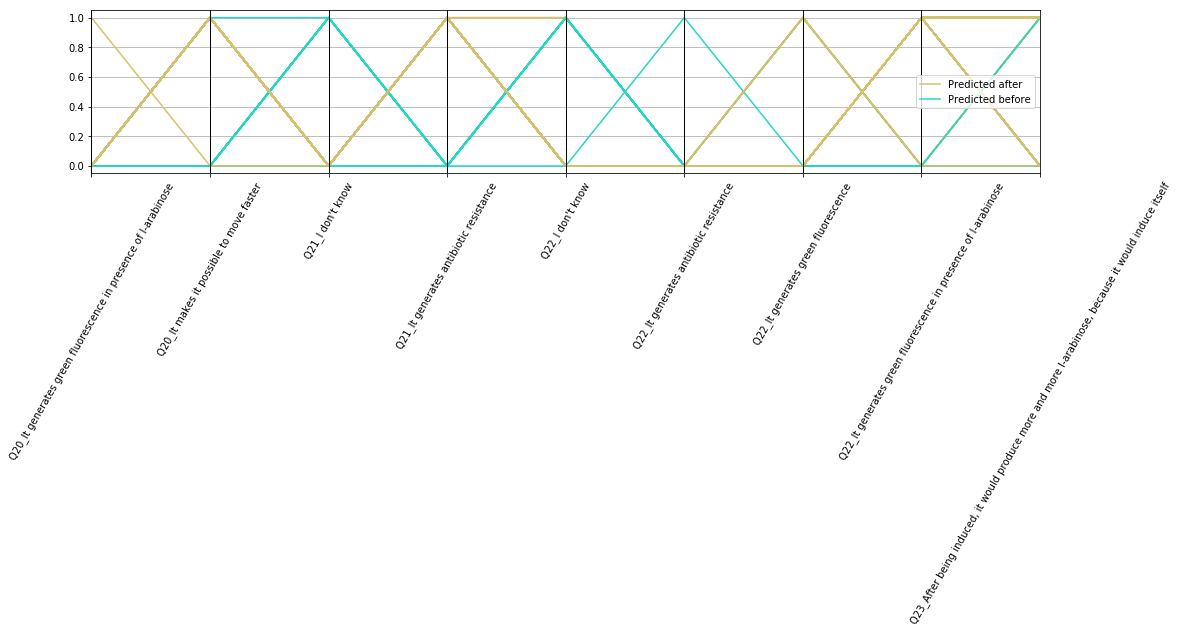

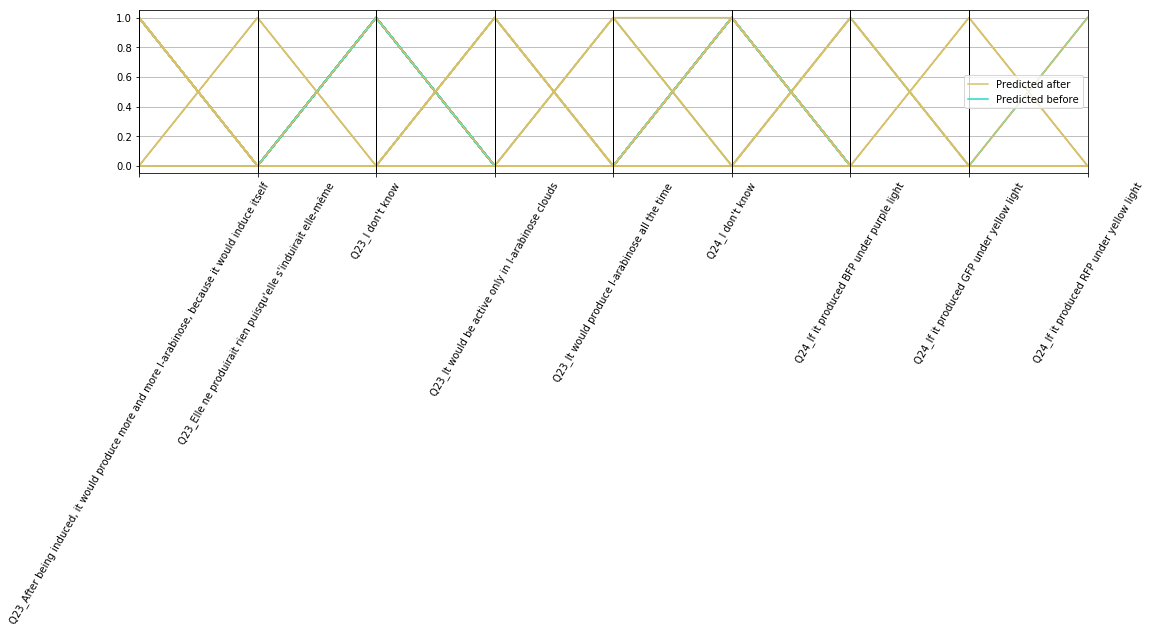

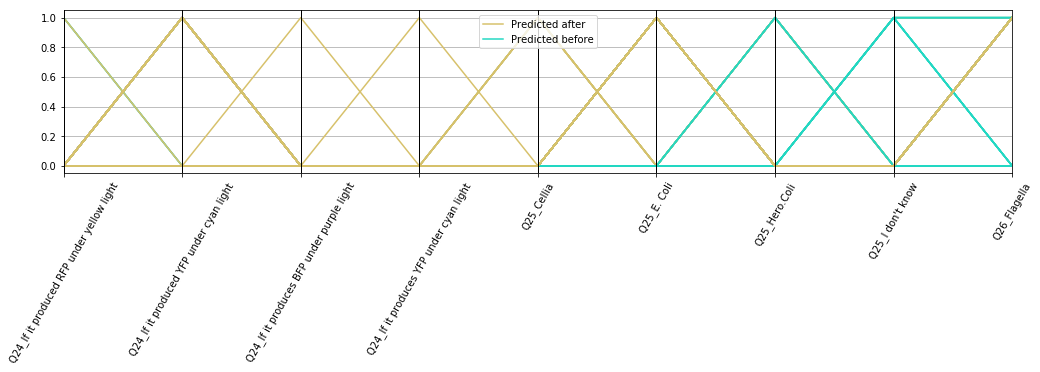

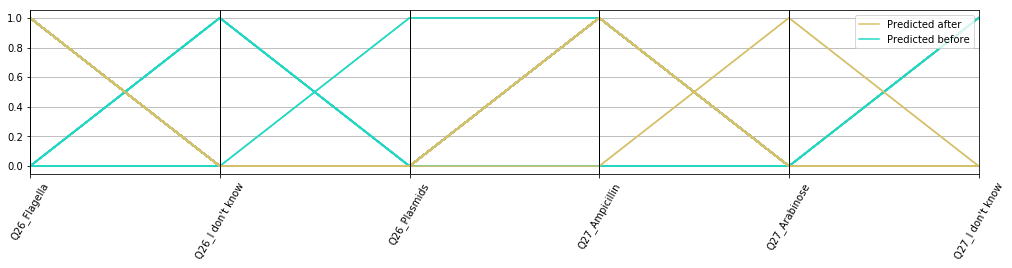

,Predicted after,Predicted before
Actual after,25,3
Actual before,13,65


In [70]:
# Display parallel coordinates plot and confusion matrix
assignements = detailsKmeans(defForms, defResults, 2, displayParallelCoord=True, clusterLabels=["Predicted after", "Predicted before"])
assignements = pd.concat([assignements, defForms["temporality"]], axis=1, join='inner')
defConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defConfusionMat = pd.DataFrame(data = defConfusionMat, columns=["Predicted after", "Predicted before"], index = ["Actual after", "Actual before"])
defConfusionMat

Conclusion: Hypothesis verified. Parallel coordinates plot is not very informative because of the high number of features and the high proportion of binary features, use only for data exploration (30/12/2017)

### If all questionnaires are used

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


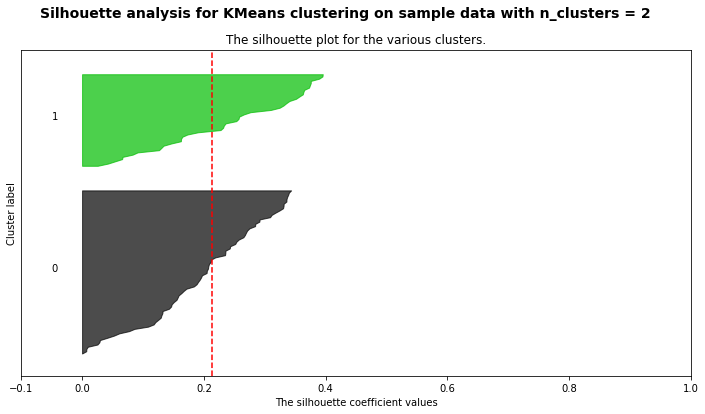

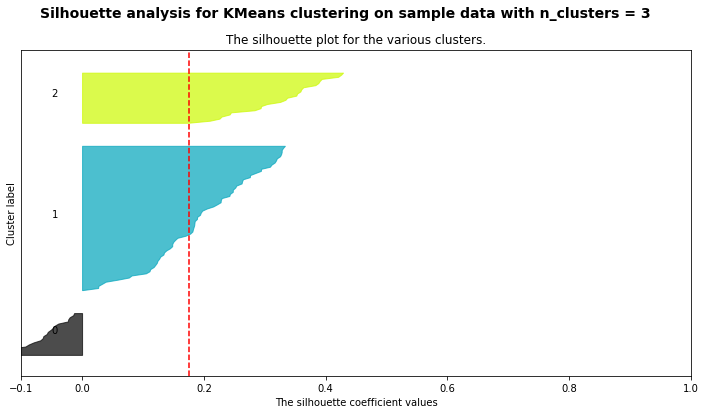

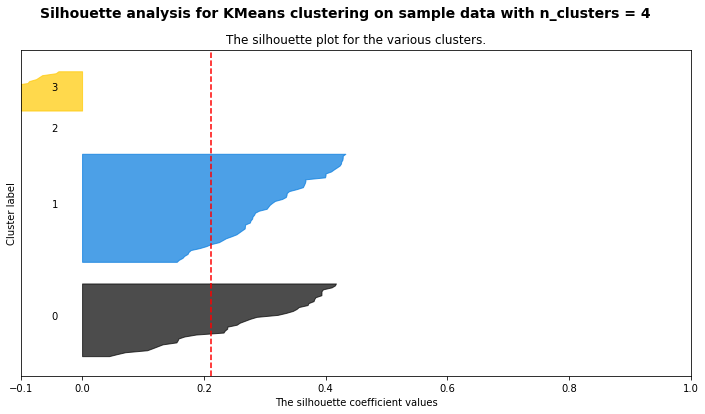

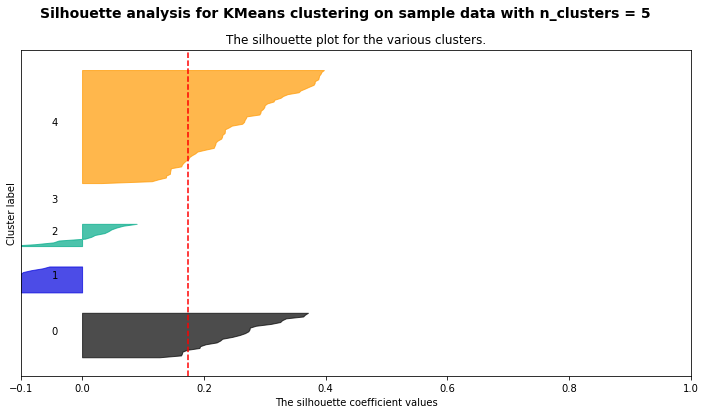

,Number of clusters,Average silhouette score,Label assignements
0,2,0.213051,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,3,0.175737,"[1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, ..."
2,4,0.211633,"[3, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,5,0.174565,"[4, 4, 1, 4, 4, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, ..."


In [71]:
# Convert DataFrame to matrix
allMat = allForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allMat = preprocessing.scale(allMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allResults = tryKmeans(allMat)
# Format results as a DataFrame
allResults = pd.DataFrame(data=allResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
allResults

Conclusion: The data could be clustered in two groups (30/11/2017)

In [72]:
assignements = detailsKmeans(allForms, allResults, 2)
assignements = pd.concat([assignements, allForms["temporality"]], axis=1, join='inner')
defConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defConfusionMat = pd.DataFrame(data = defConfusionMat, columns=["Predicted undefined", "Predicted before", "Predicted after"], index = ["Actual undefined", "Actual after", "Actual before"])
defConfusionMat.drop("Predicted undefined", axis=1, inplace=True)
defConfusionMat

,Predicted before,Predicted after
Actual undefined,6,4
Actual after,3,25
Actual before,65,13


Conclusion: Compared to previous test, the presence of questionnaire that were realised neither just before nor just after the play test is not detected, but it does not impact the prediction of the before and after temporalities (30/11/2017)

TODO RAPHAEL : Manually check the undefined temporalities

## If scientific questions are coded by correctedness

### If only before and after questionnaires are used

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


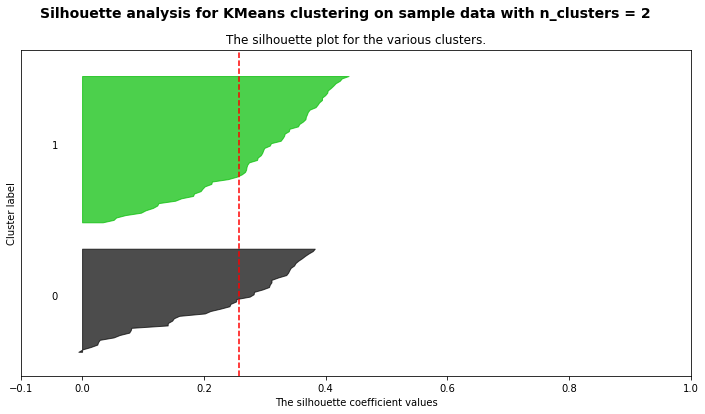

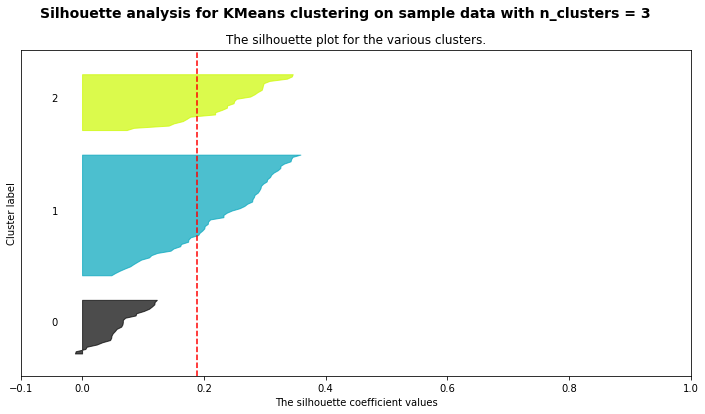

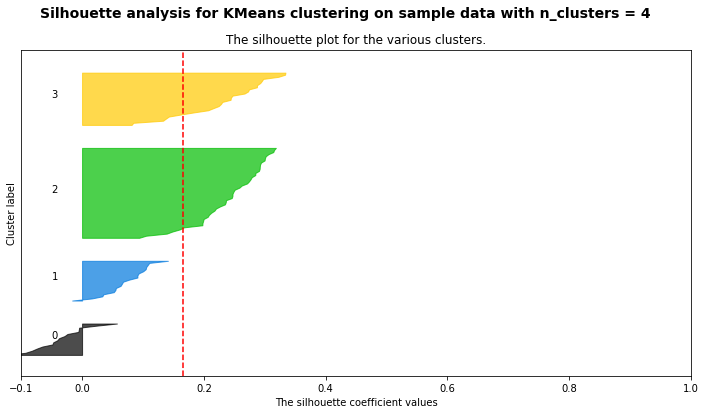

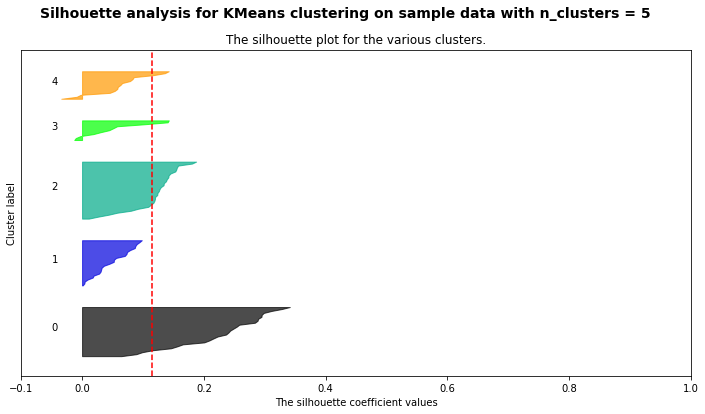

,Number of clusters,Average silhouette score,Label assignements
0,2,0.258054,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,0.189036,"[0, 1, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, ..."
2,4,0.165381,"[0, 0, 1, 0, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, ..."
3,5,0.114805,"[2, 2, 3, 1, 0, 0, 0, 0, 0, 4, 4, 3, 0, 0, 0, ..."


In [73]:
# Convert DataFrame to matrix
defCorrectedMat = defCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defCorrectedMat = preprocessing.scale(defCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defCorrectedResults = tryKmeans(defCorrectedMat)
# Format results as a DataFrame
defCorrectedResults = pd.DataFrame(data=defCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
defCorrectedResults

Conclusion: The data could be clustered in two groups and the clustering is slightly better than with scientific questions coded by answers
Note: The silhouette coefficient probably never goes very high because of the binary aspect of most of the data (01/12/2017)

Hypothesis: The two groups identified by the clustering algorithm correspond to the "before" and "after" questionnaires.
Note: The temporality feature was not included in the clustering algorithm

Will split columns into 6 groups


A Jupyter Widget

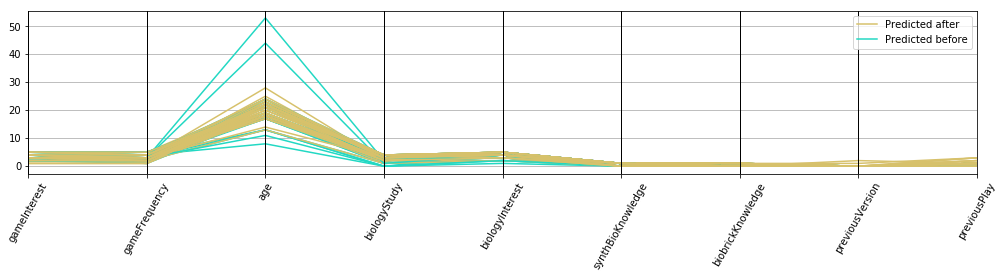

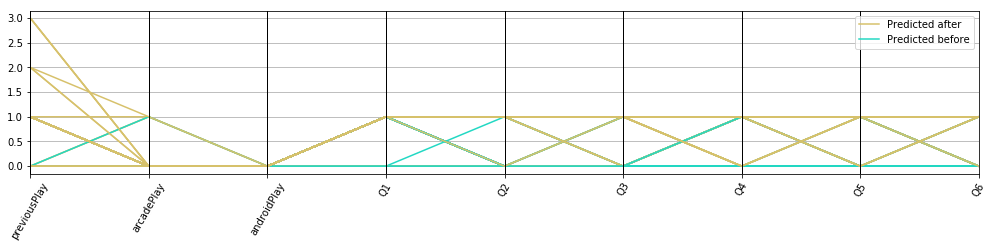

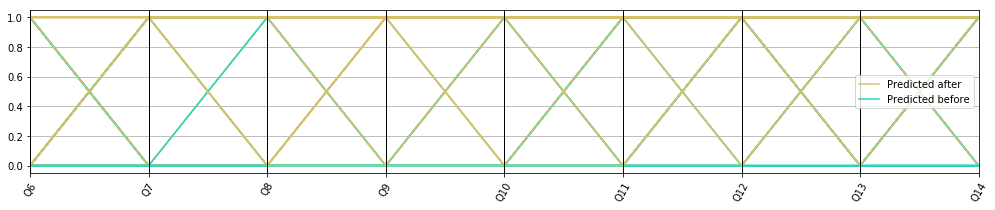

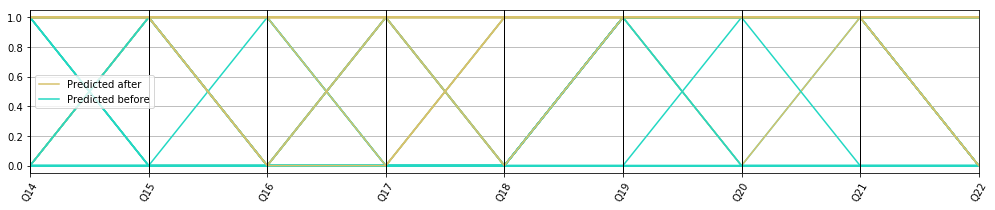

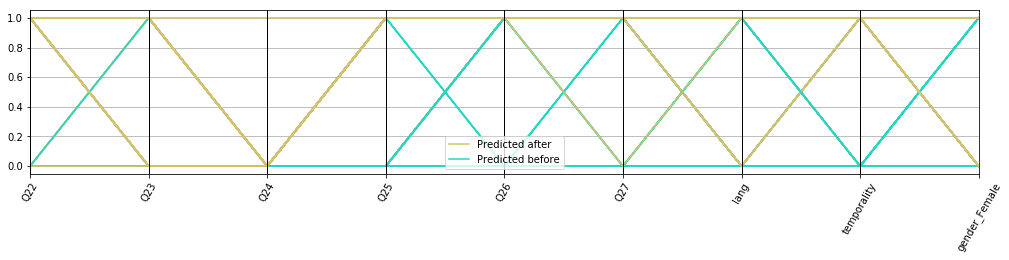

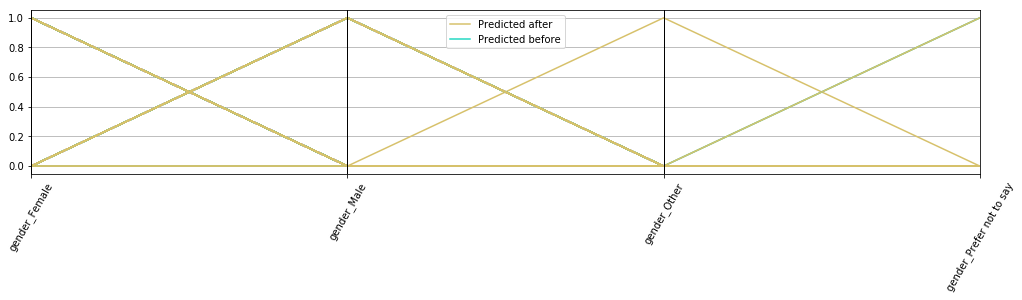

,Predicted after,Predicted before
Actual after,25,3
Actual before,19,59


In [74]:
assignements = detailsKmeans(defCorrectedForms, defCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Predicted after", "Predicted before"])
assignements = pd.concat([assignements, defCorrectedForms["temporality"]], axis=1, join='inner')
defCorrectedConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defCorrectedConfusionMat = pd.DataFrame(data = defCorrectedConfusionMat, columns=["Predicted after", "Predicted before"], index = ["Actual after", "Actual before"])
defCorrectedConfusionMat

Conclusion: Hypothesis verified. Parallel coordinates plot is not very informative because of the high proportion of binary features, use only for data exploration (30/12/2017)

### If all questionnaires are used

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


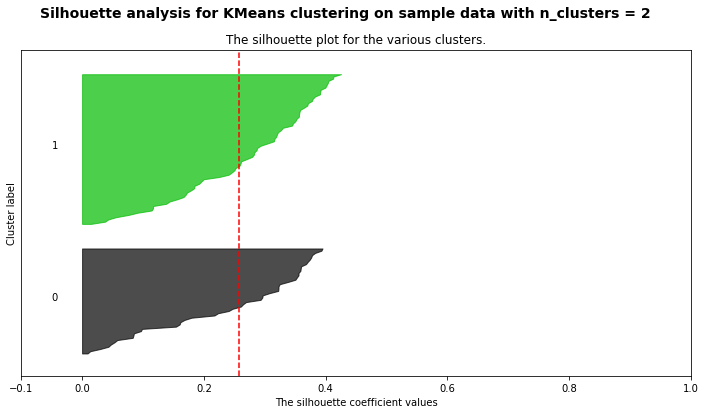

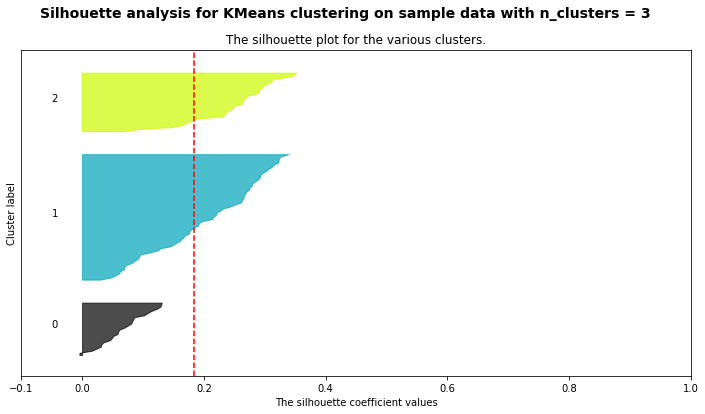

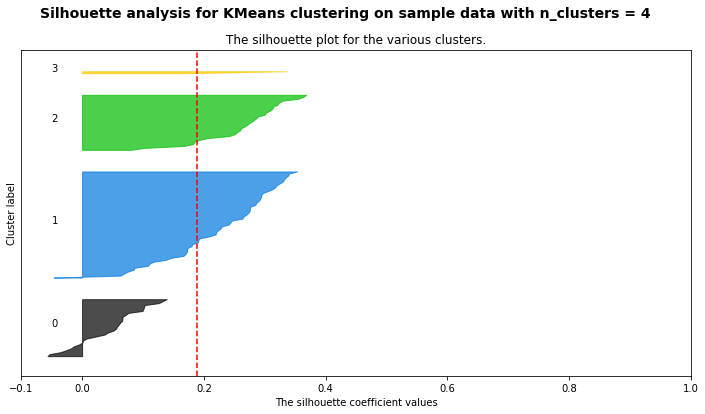

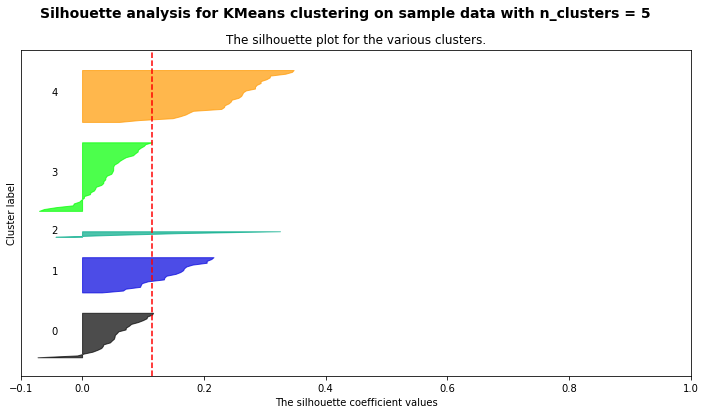

,Number of clusters,Average silhouette score,Label assignements
0,2,0.258487,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,0.184110,"[0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, ..."
2,4,0.188321,"[0, 1, 0, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, ..."
3,5,0.114114,"[3, 2, 0, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, ..."


In [75]:
# Convert DataFrame to matrix
allCorrectedMat = allCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allCorrectedMat = preprocessing.scale(allCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allCorrectedResults = tryKmeans(allCorrectedMat)
# Format results as a DataFrame
allCorrectedResults = pd.DataFrame(data=allCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
allCorrectedResults

Conclusion: The data could be clustered in two groups. Three groups could be interesting but not enough data points in third cluster to conclude. (30/11/2017)

Will split columns into 6 groups


A Jupyter Widget

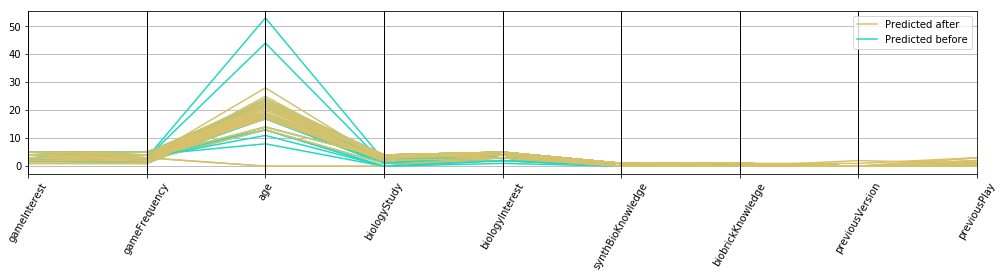

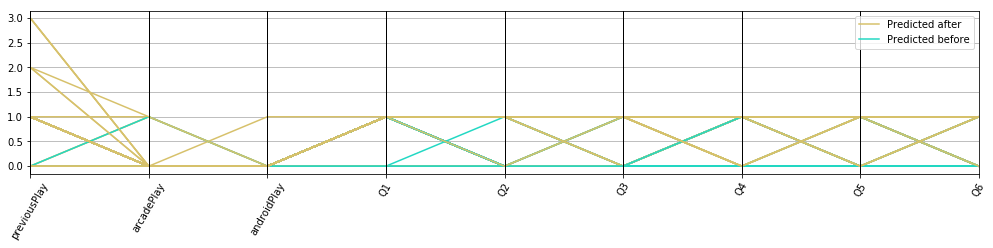

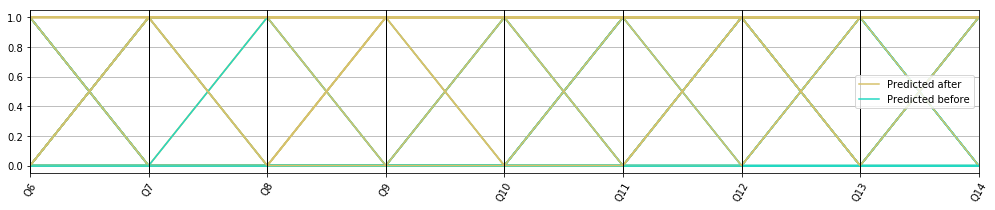

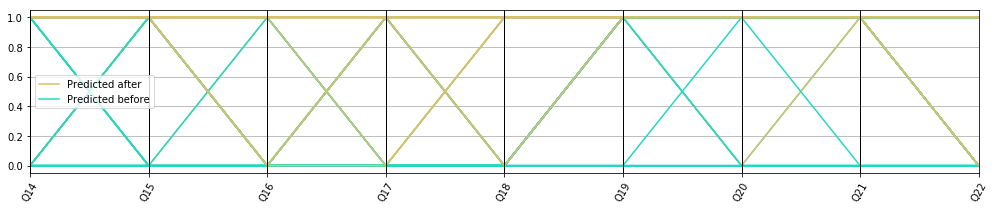

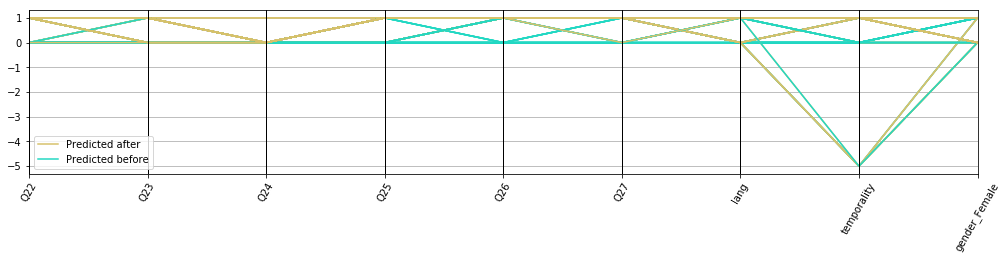

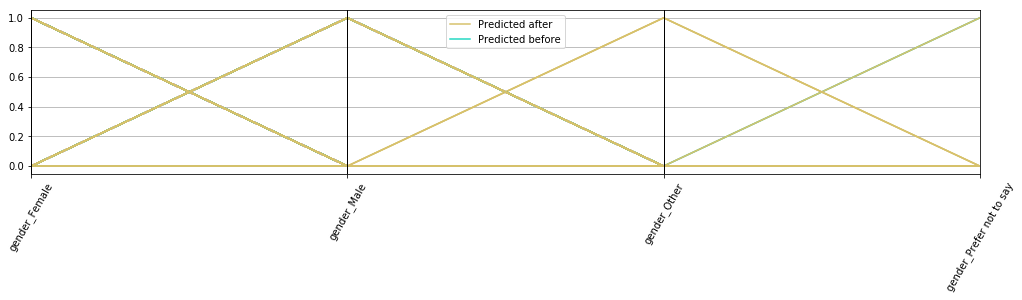

,Predicted after,Predicted before
Actual undefined,4,6
Actual after,25,3
Actual before,19,59


In [76]:
assignements = detailsKmeans(allCorrectedForms, allCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Predicted after", "Predicted before"])
assignements = pd.concat([assignements, allCorrectedForms["temporality"]], axis=1, join='inner')
defCorrectedConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defCorrectedConfusionMat = pd.DataFrame(data = defCorrectedConfusionMat, columns=["Predicted undefined", "Predicted after", "Predicted before"], index = ["Actual undefined", "Actual after", "Actual before"])
defCorrectedConfusionMat.drop("Predicted undefined", axis=1, inplace=True)
defCorrectedConfusionMat

Conclusion: Compared to previous test, the presence of questionnaire that were realised neither just before nor just after the play test is not detected, but it does not impact the prediction of the before and after temporalities (01/12/2017)

TODO RAPHAEL : Manually check the undefined temporalities

# Can data be clustered according to the answers given to both the before and the after questionnaire?

## If scientific questions are coded by answers

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


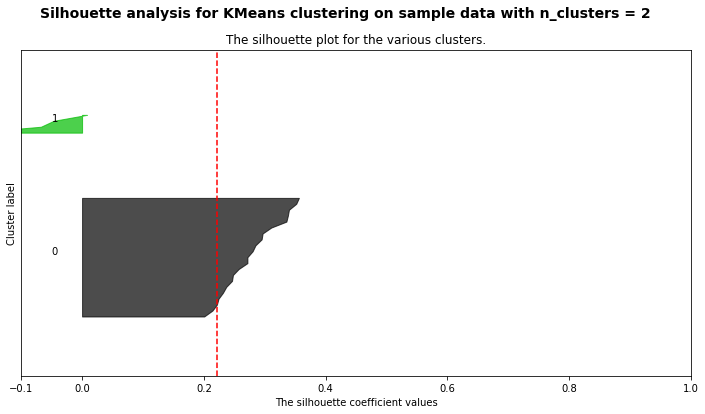

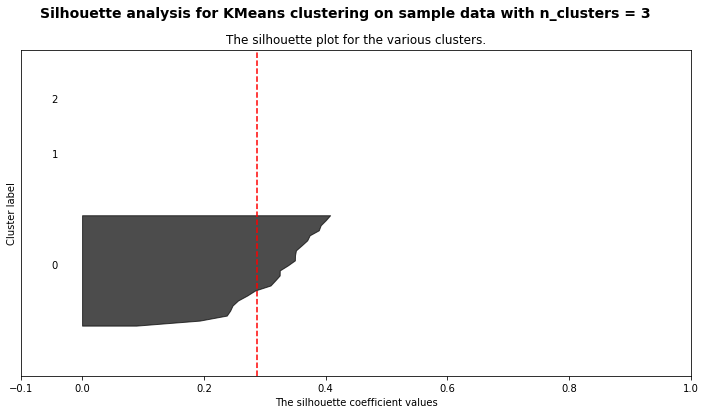

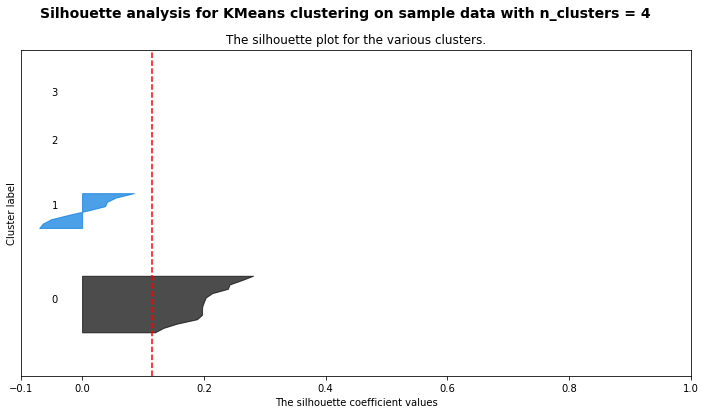

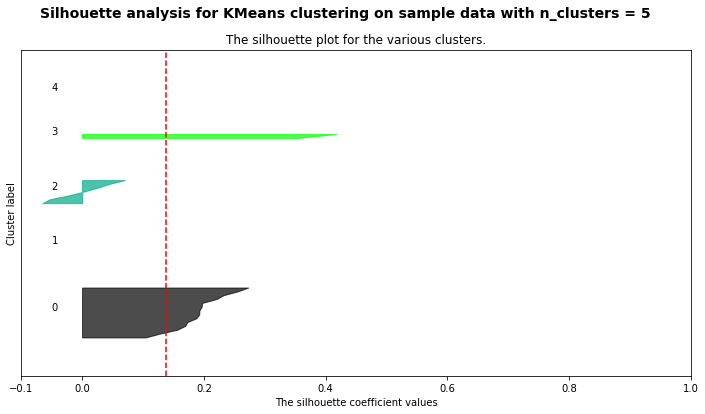

,Number of clusters,Average silhouette score,Label assignements
0,2,0.221001,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
1,3,0.287202,"[0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,4,0.114069,"[0, 0, 3, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, ..."
3,5,0.138146,"[0, 0, 1, 0, 2, 0, 2, 0, 0, 4, 0, 0, 0, 2, 3, ..."


In [77]:
# Convert DataFrame to matrix
beforeAndAfterMat = beforeAndAfterForms.as_matrix()
# Standardise the data
beforeAndAfterMat = preprocessing.scale(beforeAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterResults = tryKmeans(beforeAndAfterMat)
# Format results as a DataFrame
beforeAndAfterResults = pd.DataFrame(data=beforeAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
beforeAndAfterResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

/home/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


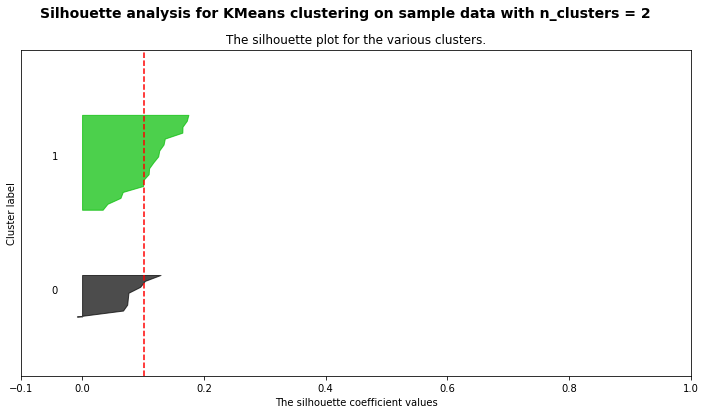

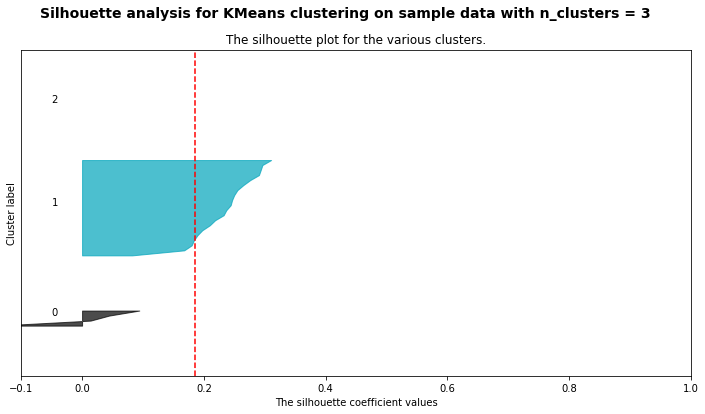

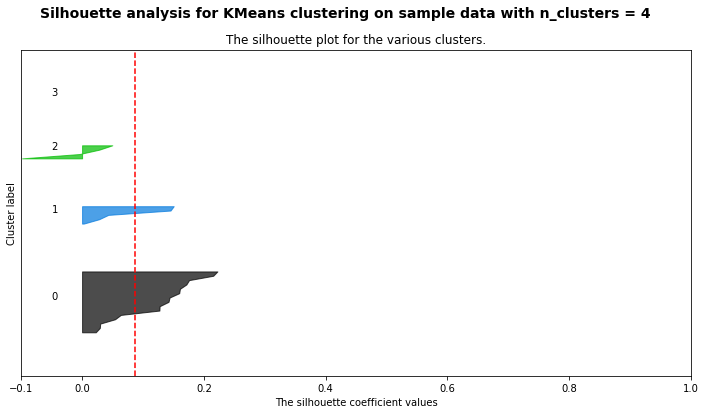

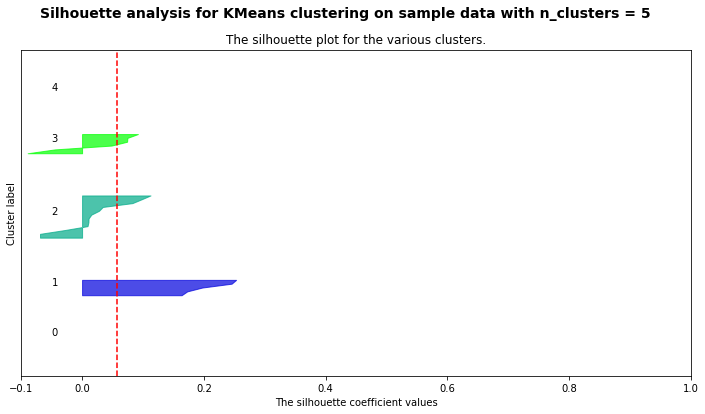

,Number of clusters,Average silhouette score,Label assignements
0,2,0.102083,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
1,3,0.185551,"[1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, ..."
2,4,0.087572,"[0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, ..."
3,5,0.056802,"[2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 3, 3, ..."


In [78]:
# Convert DataFrame to matrix
beforeAndAfterCorrectedMat = beforeAndAfterCorrectedForms.as_matrix()
# Standardise the data
beforeAndAfterCorrectedMat = preprocessing.scale(beforeAndAfterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterCorrectedResults = tryKmeans(beforeAndAfterCorrectedMat)
# Format results as a DataFrame
beforeAndAfterCorrectedResults = pd.DataFrame(data=beforeAndAfterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Label assignements'])
beforeAndAfterCorrectedResults

Conclusion: The data could be clustered in two groups (01/12/2017)

Will split columns into 11 groups


A Jupyter Widget

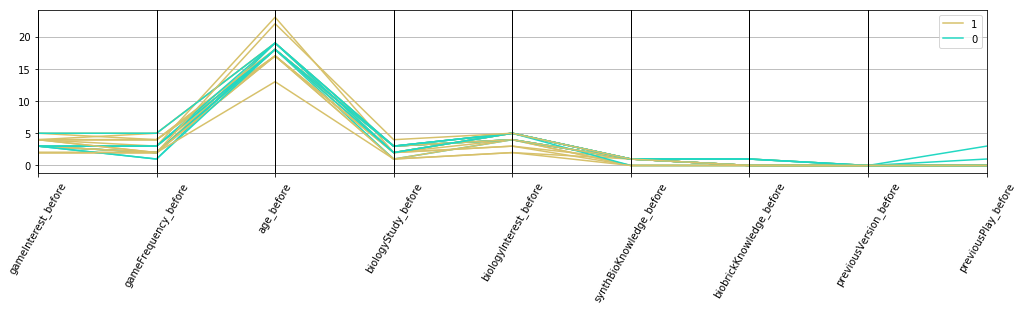

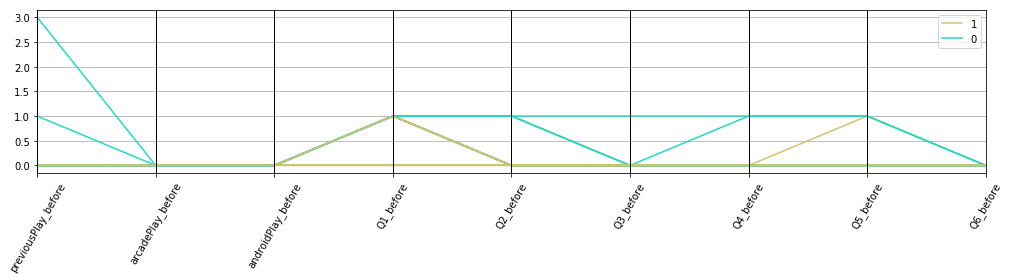

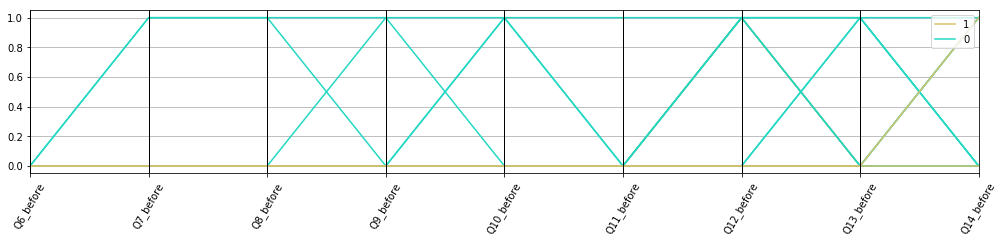

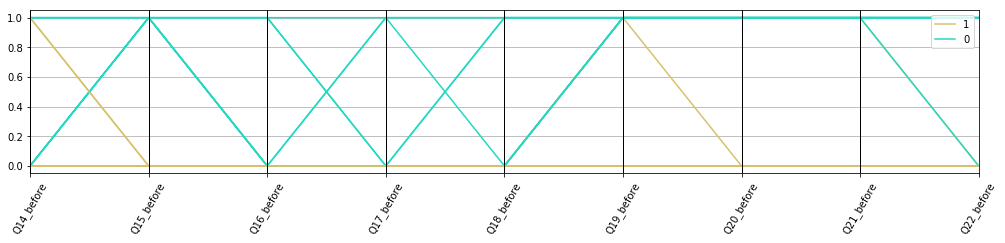

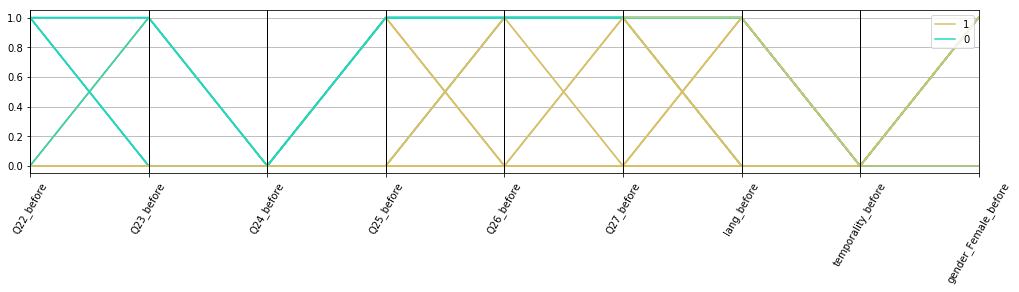

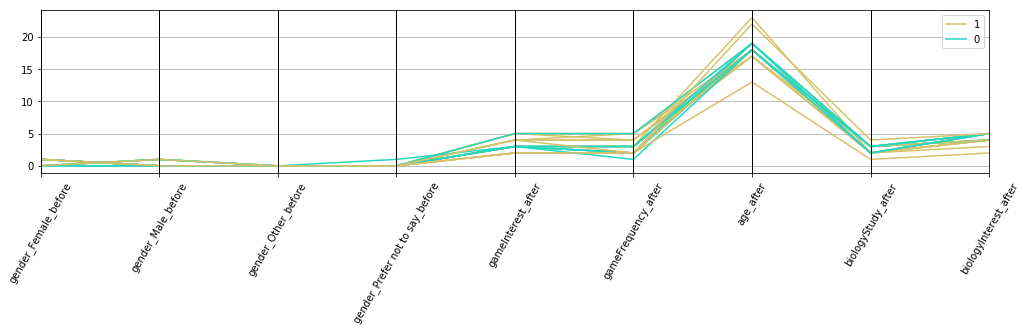

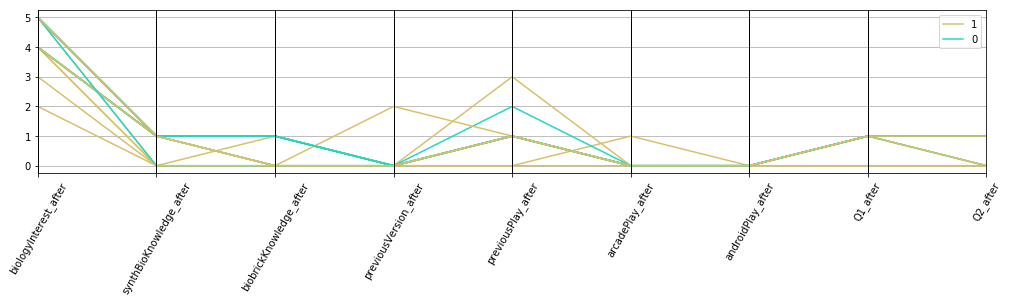

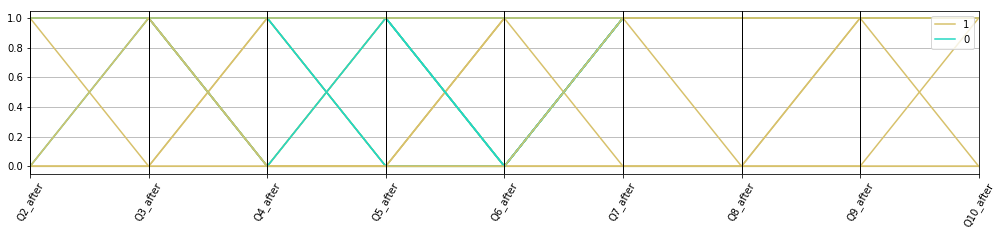

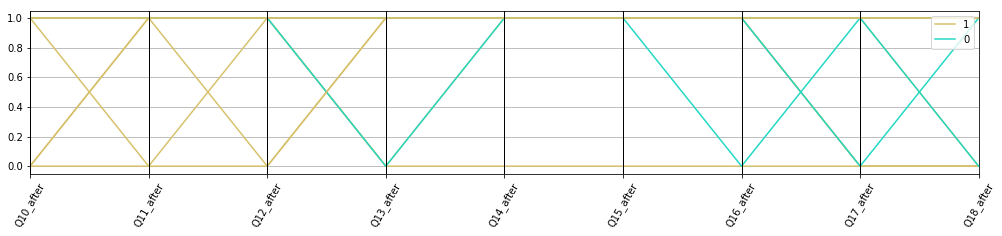

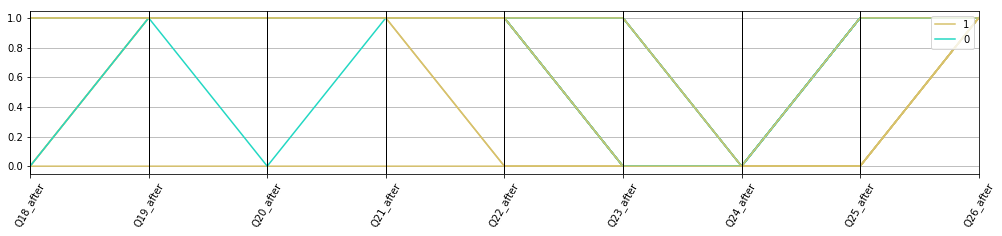

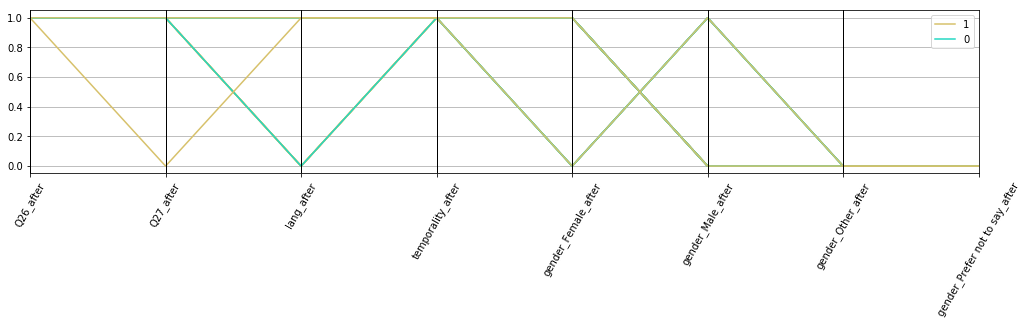

In [79]:
assignements = detailsKmeans(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, displayParallelCoord=True)

TODO Raphael: Look in details at questions